# EE 469
```
         /\_/\
        ( o.o )
         > ^ <
```

# Check GPU


In [86]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading Dataset on DataFrame

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
directory = "/content/drive/MyDrive/EE469_Project"

In [89]:
import multiprocessing as mp
import os
import pandas as pd
import glob


def read_folder(filename):
    return filename


def load_dataset(directory):
    data = []
    rgb_files = glob.glob(os.path.join(directory, "rgb_images") + "/*")
    for file in rgb_files:
        name = os.path.basename(file)
        name, ext = os.path.splitext(name)
        seg_file = os.path.join(
            directory, "segmented_images", name + "_mask.png"
        )
        if os.path.exists(seg_file):
            data.append((name, file, seg_file))
        else:
            print("%s does not have masked version." % name)

    df = pd.DataFrame(
        data, columns=["file_name", "path_to_rgb", "path_to_seg"]
    )
    return df


df = load_dataset(directory)

In [90]:
df


,file_name,path_to_rgb,path_to_seg
0,00320,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
1,01176,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
2,00917,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
3,02132,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
4,00080,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
...,...,...,...
1291,00254,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
1292,00446,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
1293,02127,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
1294,02126,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...


# Splitting Dataset

In [91]:
import numpy as np

seed = 69

df_shuffled = df.sample(frac=1, random_state=seed)

total_rows = len(df_shuffled)
split1 = int(0.1 * total_rows)
split2 = int(0.2 * total_rows)

df_20_1 = df_shuffled[:split1]
df_20_2 = df_shuffled[split1:split2]
df_60 = df_shuffled[split2:]

In [92]:
val = df_20_1
test = df_20_2
train = df_60

print(len(val))
print(len(test))
print(len(train))
print(len(test) + len(val)+ len(train))


129
130
1037
1296


In [ ]:
train

# CNN Model

## Architecture

In [93]:
import cv2 as cv
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras import layers
from keras.layers import Input
from keras.models import Model
from keras.layers import (
    Conv2DTranspose,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    SeparableConv2D,
    Lambda,
    BatchNormalization
)


def encoder_layer(input, filters):
  conv = Conv2D(filters, 3, activation="relu", padding="same")(input)
  conv = layers.BatchNormalization()(conv)
  conv = Conv2D(filters, 3, activation="relu", padding="same")(conv)
  conv = layers.BatchNormalization()(conv) # 32
  pool = MaxPooling2D(pool_size=(2, 2))(conv) # 16

  return pool, conv


def decoder_layer(input, prev_conv, filter):
  up = Conv2DTranspose(filter, (2, 2), strides=(2, 2), padding='same')(input)

  up = concatenate([up, prev_conv], axis=-1)

  conv = Conv2D(filter, 3, activation="relu", padding="same")(up)
  conv = layers.BatchNormalization()(conv)
  conv = Conv2D(filter, 3, activation="relu", padding="same")(conv)
  conv = layers.BatchNormalization()(conv)

  return conv


def my_model(normlayer=None):
    inputs = Input(shape=(256, 256, 3))

    # Encoder
    pool1, conv1 = encoder_layer(inputs, 32) # 128
    pool2, conv2 = encoder_layer(pool1, 64) # 64
    pool3, conv3 = encoder_layer(pool2, 128) # 32, 64
    pool4, conv4 = encoder_layer(pool3, 256) # 16, 32

    # Bottom
    conv6 = Conv2D(512, 3, activation="relu", padding="same")(pool4)
    conv6 = layers.BatchNormalization()(conv6)

    conv7 = Conv2D(512, 3, activation="relu", padding="same")(conv6) # 16
    conv7 = layers.BatchNormalization()(conv7)

    # Decoder
    decoder2 = decoder_layer(conv7, conv4, 256) # 16 * 2, 32
    decoder3 = decoder_layer(decoder2, conv3, 128) # 32, 32
    decoder4 = decoder_layer(decoder3, conv2, 64)
    decoder5 = decoder_layer(decoder4, conv1, 32)

    # Head
    outputs = Conv2D(1, 1, activation="sigmoid")(decoder5)

    model = Model(inputs, outputs=outputs)
    return model

In [94]:
model = my_model()

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_228 (Conv2D)         (None, 256, 256, 32)         896       ['input_13[0][0]']            
                                                                                                  
 batch_normalization_216 (B  (None, 256, 256, 32)         128       ['conv2d_228[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_229 (Conv2D)         (None, 256, 256, 32)         9248      ['batch_normalization_2

## Visualization and Stats of the Model

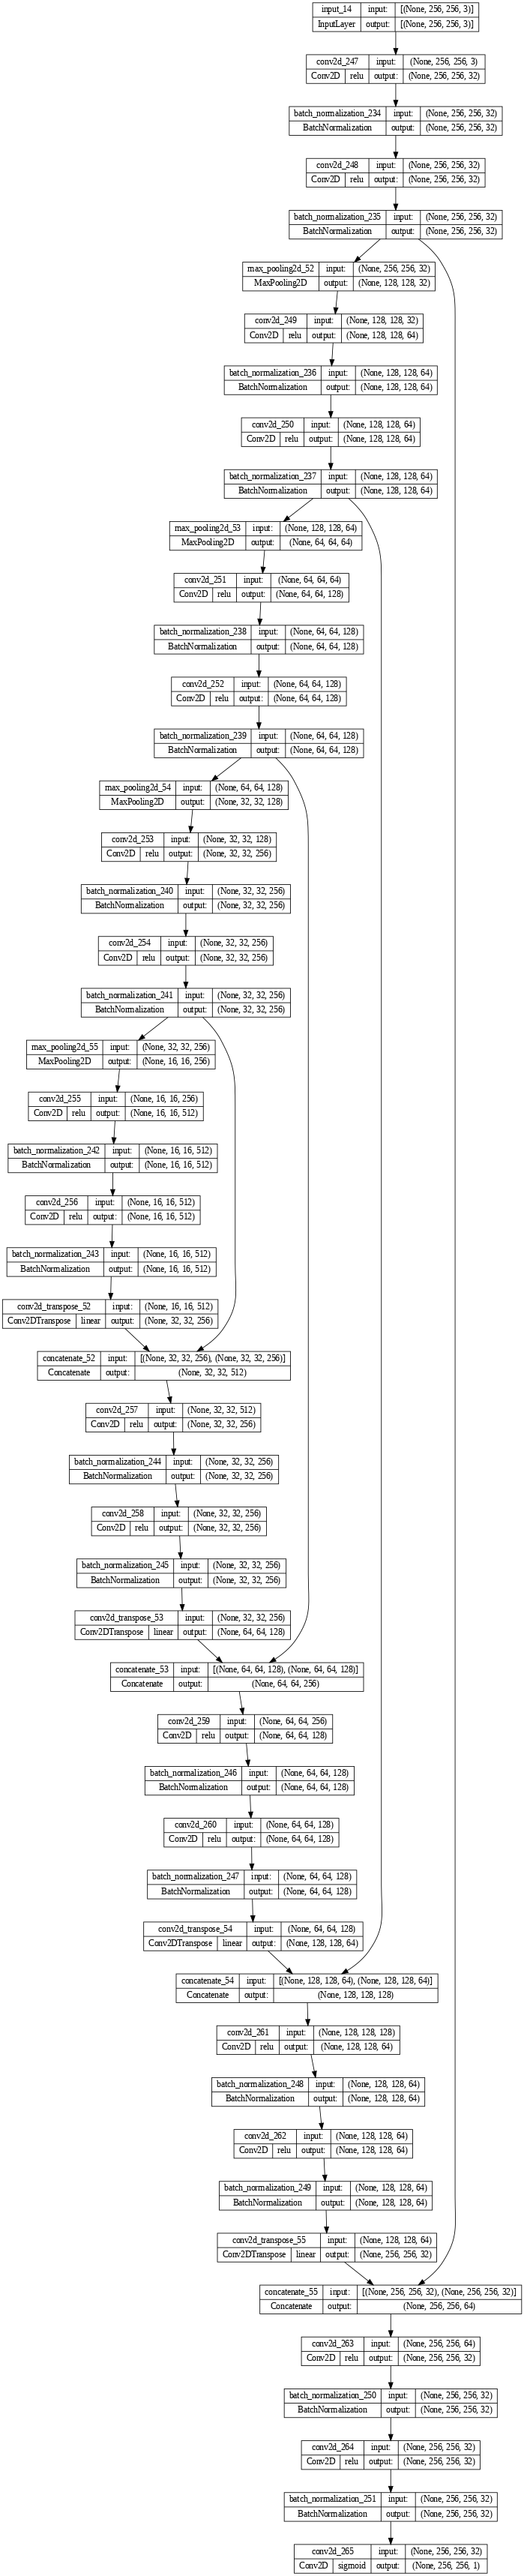

In [95]:
model = my_model()

tf.keras.utils.plot_model(model,
                          expand_nested=True,
                          dpi=60,
                          show_shapes=True,
                          show_layer_activations=True)


In [96]:
model = my_model()

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_266 (Conv2D)         (None, 256, 256, 32)         896       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_252 (B  (None, 256, 256, 32)         128       ['conv2d_266[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_267 (Conv2D)         (None, 256, 256, 32)         9248      ['batch_normalization_2

# Preprocessing Images

## Augmentation and Parallel Loading Functions

In [97]:
import PIL
from PIL import Image
import multiprocessing as mp
import threading
from PIL import ImageEnhance
import random
from concurrent.futures import ThreadPoolExecutor
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables import SegmentationMapsOnImage


def read_image(path):
    img_rgb = Image.open(path).resize((256, 256)).convert("RGB")

    if path.endswith(".png"):
        arr = (np.asarray(img_rgb.convert("L")) > 0).astype(int)
        return arr
    else:
        return np.asarray(img_rgb)


def augment_images(images):
    rgb_arr = images[0]
    seg_arr = (images[1]).astype(np.uint16)

    aug_list = [
        iaa.Fliplr(0.5),
        iaa.Multiply((0.8, 1.2)),
        iaa.LinearContrast((0.8, 1.2)),
        iaa.AdditiveGaussianNoise(scale=(1, 10)),
        iaa.Dropout(p=(0.02, 0.05)),
    ]

    seq = iaa.Sequential(aug_list)

    maps = [SegmentationMapsOnImage(_, shape=(256, 256)) for _ in seg_arr]

    batch = ia.Batch(images=rgb_arr, segmentation_maps=maps)

    batch_aug = seq.augment_batch_(batch)
    images_aug = batch_aug.images_aug
    segs_aug = batch_aug.segmentation_maps_aug

    return np.array(images_aug), np.array([_.get_arr() for _ in segs_aug])


def load_images_par(dataset):
    # high level multithread
    with ThreadPoolExecutor(max_workers=32) as executor:
        rgb_arr = list(executor.map(read_image, dataset["path_to_rgb"]))
        seg_arr = list(executor.map(read_image, dataset["path_to_seg"]))

    seg_arr = np.array(seg_arr)
    seg_arr = np.expand_dims(seg_arr, axis=-1)

    return np.array(rgb_arr), seg_arr

In [98]:
np.array(load_images_par(df.sample(5))[0]).shape

(5, 256, 256, 3)

In [99]:
np.array(load_images_par(df.sample(5))[1]).shape

(5, 256, 256, 1)

(1, 256, 256, 3)
(1, 256, 256)


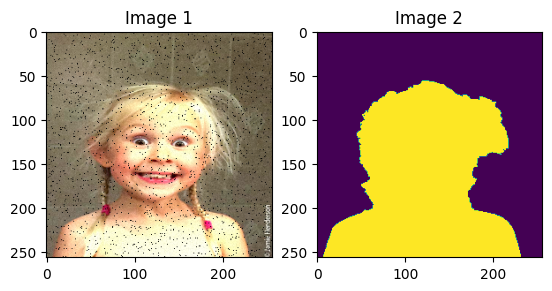

In [100]:
from matplotlib import pyplot as plt

singletest = df.sample(random_state=1).iloc[0]

img = (read_image(singletest["path_to_rgb"]), read_image(singletest["path_to_seg"]))
img = (np.expand_dims(img[0], axis=0), np.expand_dims(img[1], axis=0))

img = augment_images(img)

print(img[0].shape)
print(img[1].shape)

plt.subplot(1, 2, 1)
plt.imshow(img[0][0])
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(img[1][0])
plt.title('Image 2')

plt.show()

## Data Generator

In [101]:
import keras
from keras import preprocessing


class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=64, shuffle=False, aug=False):
        self.df = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def __getitem__(self, index):
        indexes = self.indexes[
            index * self.batch_size : (index + 1) * self.batch_size
        ]

        batch = self.df.iloc[indexes]
        X, y = load_images_par(batch)

        if self.aug:
            X, y = augment_images((X, y))
        # normalization
        X = X / 255
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### Set Data Generator

In [102]:
batch_size = 32

In [103]:
train_gen = DataGenerator(train, batch_size, True, True)
val_gen = DataGenerator(val, 32, False, False)
test_gen = DataGenerator(test, 32, False, False)

In [104]:
train_gen.__getitem__(0)[0].shape

(32, 256, 256, 3)

In [105]:
val_gen.__getitem__(0)[1].shape


(32, 256, 256, 1)

# Training

## Callbacks

In [106]:
model_class = 'model_v4'
filepath = 'model_best.h5'
filepath = os.path.join('checkpoints', model_class, filepath)


In [126]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import Callback


def get_lr(optimizer):
    lr = optimizer.learning_rate
    step = optimizer.iterations
    return lr

class LearningRateLogger(Callback):
    def on_train_begin(self, logs=None):
        self.learning_rates = []

    def on_batch_end(self, batch, logs):
        lr = get_lr(self.model.optimizer)
        logs.update({"learning_rate": lr.numpy()})

    def on_epoch_end(self, epoch, logs):
        lr = get_lr(self.model.optimizer)
        self.learning_rates.append(lr.numpy())
        logs.update({"learning_rate": lr.numpy()})


callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.01,
        verbose=1,
    ),
    ModelCheckpoint(
        filepath, monitor="val_loss", save_best_only=True, verbose=1
    ),
    LearningRateLogger()
]

## Learning Rate Schedule

In [127]:
initial_lr = 0.001
decay_steps = 200
decay_rate = 0.87

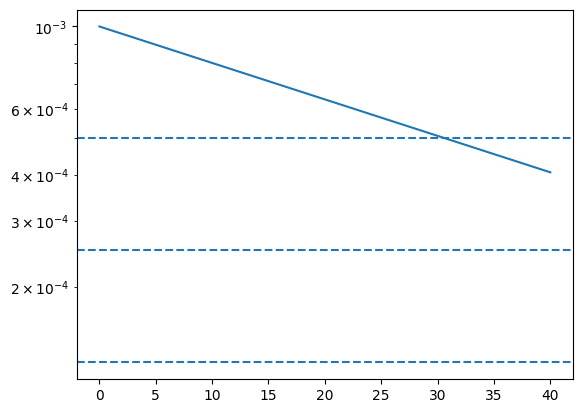

In [128]:
from matplotlib import pyplot as plt

a = len(train) / batch_size

x = np.linspace(0, a * 40)
y = initial_lr * (decay_rate ** (x / decay_steps))
x = x / a

plt.semilogy(x, y)
plt.axhline(y=0.0005, linestyle='--')
plt.axhline(y=0.00025, linestyle='--')
plt.axhline(y=0.000125, linestyle='--')
plt.show()


## Fit

In [129]:
histories = []

### All at once

In [130]:
model = my_model()
histories = []

In [131]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 40

lr = ExponentialDecay(
    initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks
)

# history.history['learning_rate'] = lr_logger.learning_rates
# histories.append(history)


Epoch 1/40
33/33 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.7548 - learning_rate: 0.0010
Epoch 1: val_loss improved from inf to 3.30503, saving model to checkpoints/model_v4/model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 43s 931ms/step - loss: 0.5101 - accuracy: 0.7548 - learning_rate: 0.0010 - val_loss: 3.3050 - val_accuracy: 0.7075
Epoch 2/40
33/33 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8558 - learning_rate: 0.0010
Epoch 2: val_loss improved from 3.30503 to 2.89057, saving model to checkpoints/model_v4/model_best.h5
33/33 [==============================] - 28s 845ms/step - loss: 0.3498 - accuracy: 0.8558 - learning_rate: 0.0010 - val_loss: 2.8906 - val_accuracy: 0.6996
Epoch 3/40
33/33 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8749 - learning_rate: 0.0010
Epoch 3: val_loss improved from 2.89057 to 2.27179, saving model to checkpoints/model_v4/model_best.h5
33/33 [==============================] - 31s 904ms/step - loss: 0.3066 - accuracy: 0.8749 - learning_rate: 0.0010 - val_loss: 2.2718 - val_accuracy: 0.7892
Epoch 4/40
33/33 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.8

In [132]:
model.load_weights(filepath)


In [133]:
tf.keras.backend.clear_session()


# Plot

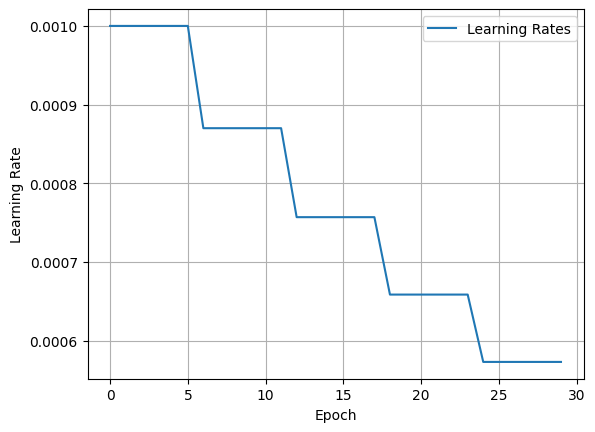

In [134]:
plt.plot(callbacks[2].learning_rates, label='Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.show()

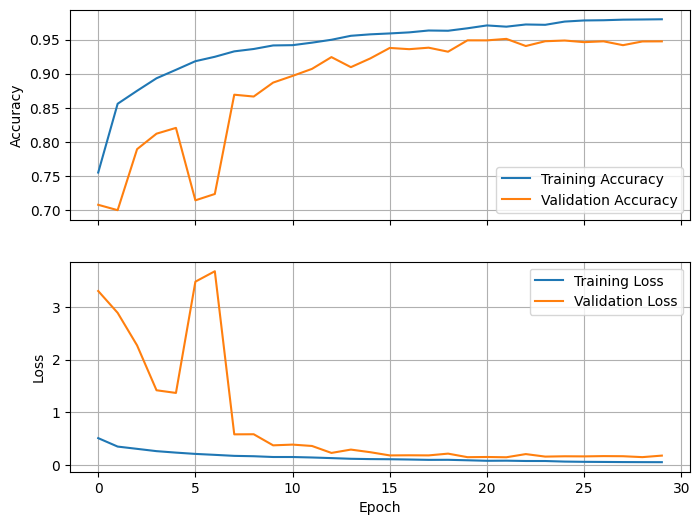

In [135]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot training history for accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot training history for loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()


# Testing

## Single Test

In [136]:
test

,file_name,path_to_rgb,path_to_seg
1066,00125,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
715,01153,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
125,00024,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
43,00122,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
18,00719,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
...,...,...,...
916,00499,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
266,00624,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
319,00418,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...
503,00211,/content/drive/MyDrive/EE469_Project/rgb_image...,/content/drive/MyDrive/EE469_Project/segmented...


/content/drive/MyDrive/EE469_Project/rgb_images/00399.jpg


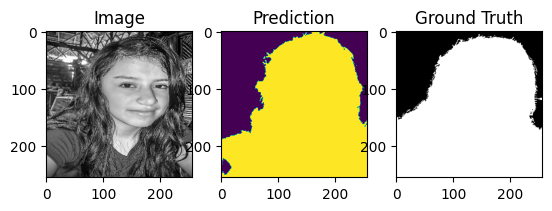

/content/drive/MyDrive/EE469_Project/rgb_images/00456.jpg


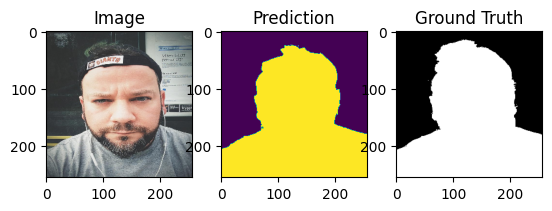

/content/drive/MyDrive/EE469_Project/rgb_images/00931.jpg


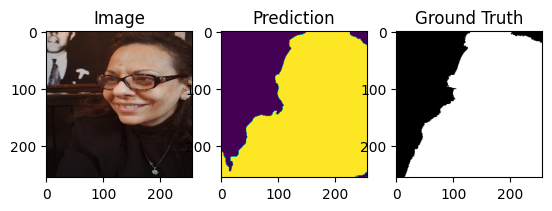

/content/drive/MyDrive/EE469_Project/rgb_images/00342.jpg


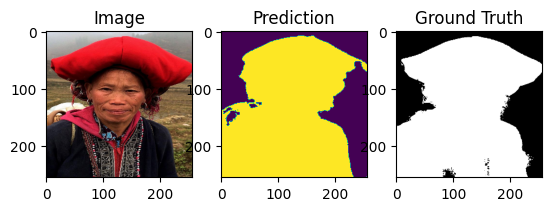

/content/drive/MyDrive/EE469_Project/rgb_images/00117.jpg


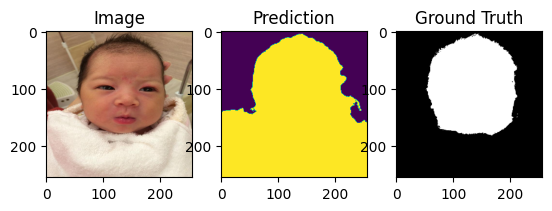

In [137]:
import cv2 as cv


def single_test(df):
    singletest = test.sample()
    print(singletest["path_to_rgb"].iloc[0])
    img = cv.imread(singletest.iloc[0]["path_to_rgb"])[:, :, ::-1]

    img_ground = cv.imread(singletest.iloc[0]["path_to_seg"])[:, :, ::-1]
    img_ground = cv.resize(img_ground, (256, 256))


    img = cv.resize(img, (256, 256))
    img = np.expand_dims(img, axis=0)

    out = model.predict(img / 255, verbose=False)
    out = out > 0.5

    plt.subplot(1, 3, 1)
    plt.imshow(img[0])
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(out[0])
    plt.title("Prediction")

    plt.subplot(1, 3, 3)
    plt.imshow(img_ground)
    plt.title("Ground Truth")

    plt.show()


single_test(test)
single_test(test)
single_test(test)
single_test(test)
single_test(test)

## Load Model from Checkpoint

In [138]:
model.save("model_best")

In [139]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['batch_normalization[0][0

## Evaluation

In [141]:
outstats = model.evaluate(test_gen, verbose=False)
outstats


[0.15228082239627838, 0.9479851126670837]